# Basic simulation analysis

In this notebook you will run some basic analyses and plots on a simulation.

The simulation you are going to analyse has the following parameters:
- all neurons are simulated
- duration of 1000 ms
- projections (Schaffer collaterals) included
- spontaneous synaptic activity (minis) at 0.01 Hz

---

Import some python packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# package to work with the circuit
from bluepysnap import Simulation
from bluepysnap.bbp import Cell

Fix the seed

In [2]:
np.random.seed(12)

Get the simulation data and create the simulation object

In [3]:
sim = Simulation("/home/data-bbp/20191017/simulations/activate_minis/minis/simulation_config.json")

Get the global spikes report and the specific hippocampus one

In [4]:
spikes = sim.spikes
hippocampus_spikes = spikes["hippocampus_neurons"]

Get the hippocampus neurons which spiked and check the properties of the spiking neurons

In [5]:
hippocampus_spikes.nodes.get(group=hippocampus_spikes.node_ids).head()

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
145,cACpyr,SP,hoc:CA1_pyr_cACpyr_oh140807_A0_idB_2019030510521,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc0;SP,3.141593,-1.256615,3.141593,EXC,475.613040,214.946340,418.594196,-0.116927,0.263672
277,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc4;SP,0.000000,-0.582821,0.000000,EXC,102.885407,205.698670,820.509814,-0.121854,0.283203
427,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC,SP_PC,mc4;SP,-3.141593,0.308174,-3.141593,EXC,151.772716,170.433333,808.895026,-0.126112,0.283203
602,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.927936,-3.141593,EXC,175.807845,215.114387,620.637111,-0.121854,0.283203
669,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc6;SP,3.141593,-1.197367,3.141593,EXC,569.932009,173.500045,760.627625,-0.121668,0.278320


Filter the report on SP_PC cells from the mc2 column only

In [6]:
filtered_spikes = spikes.filter(group={Cell.MTYPE: 'SP_PC', 'region': {'$regex': "mc2.*"}})

In [7]:
filtered_spikes.report.head()

,ids,population
times,,
0.850,11998,hippocampus_neurons
3.075,2715,hippocampus_neurons
3.150,602,hippocampus_neurons
3.150,3311,hippocampus_neurons
3.150,13362,hippocampus_neurons


In [8]:
# Hack : cell we need to remove with a better simulation
times = filtered_spikes.report.index.values
filtered_spikes.report.loc[times.max() + 0.15] = [3311, "hippocampus_neurons"]
times = filtered_spikes.report.index.values
filtered_spikes.report.loc[times.max() + 0.15] = [602, "hippocampus_neurons"]

Spiking neurons and number of spikes per neurons during the simulation for the filtered cells

In [9]:
node_ids, nb_spikes = np.unique(filtered_spikes.report["ids"], return_counts=True)

Get full set of properties for neurons which spikes more than once

In [10]:
hippocampus_spikes.nodes.get(group=node_ids[nb_spikes > 1])

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
602,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.927936,-3.141593,EXC,175.807845,215.114387,620.637111,-0.121854,0.283203
3311,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,0.000000,-0.839371,0.000000,EXC,478.186235,187.794660,703.596068,-0.121854,0.283203


Get full set of  properties for neurons which spikes only once

In [11]:
hippocampus_spikes.nodes.get(group=node_ids[nb_spikes == 1]).head()

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
1714,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,1.039324,-3.141593,EXC,490.933421,203.071957,597.541707,-0.119277,0.273438
2715,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-051208AM2_axon-mpg141017_a1-2_idC_-_Scale...,SP_PC,mc2;SP,-3.141593,1.030332,-3.141593,EXC,175.621672,183.419388,554.138482,-0.083050,0.234375
4011,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.346358,-3.141593,EXC,494.910757,199.681410,787.182700,-0.119009,0.278320
4206,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg150305_A_idB_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,0.000000,-0.196576,0.000000,EXC,379.640730,226.106078,574.972647,-0.201783,0.390625
4770,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,3.141593,-1.113728,3.141593,EXC,393.798331,178.901977,423.565259,-0.119009,0.278320


### Raster plot

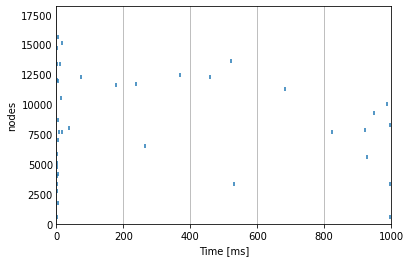

In [12]:
filtered_spikes.raster() ;

### Instantaneous frequency plot

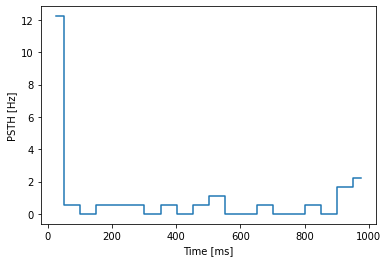

In [13]:
filtered_spikes.firing_rate_histogram() ;

### Inter-spike interval (ISI) distribution

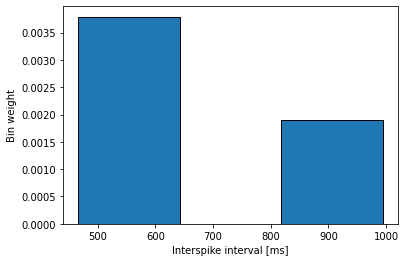

In [14]:
filtered_spikes.isi() ;

### ISI frequency distribution

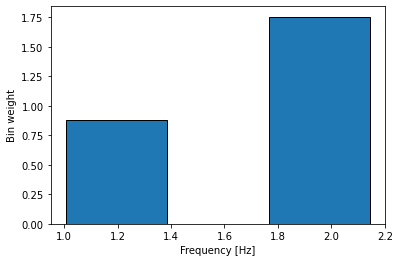

In [15]:
filtered_spikes.isi(use_frequency=True) ;

### Mean frequency distribution

In [16]:
# Function to get mean frequencies for each neuron from the report
def get_mean_frequencies():
    gb = filtered_spikes.report.groupby(["ids", "population"])
    res = []
    for _, node_spikes in gb:
        time_differences = np.diff(node_spikes.index.to_numpy())
        if len(time_differences) != 0:
            res.append(1000/time_differences.mean())
    return np.asarray(res)

In [17]:
# Function to plot the mean frequency distribution
def plot_spike_frequency(mean_frequencies, ax=None):
    
    if ax is None:
        ax = plt.gca()
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('# neurons')

    fig = plt.gcf()
    
    mean = mean_frequencies.mean()
    ax.hist(mean_frequencies)
    ax.axvline(x=mean, color='red')
    
    text = f'{mean:2.8f}'
    limits =  ax.get_xlim()
    mean_text_pos = (limits[1] - mean)/(limits[1] - limits[0]) + 0.05
    
    fig.text(mean_text_pos, 0.80, text, color='red', fontsize=12)
    
    return ax

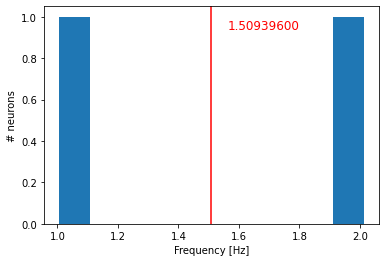

In [18]:
plot_spike_frequency(get_mean_frequencies()) ;

### Visualization

In [19]:
from IPython.display import HTML
anim, ax = filtered_spikes.firing_animation()
plt.close() # need this to avoid the first frame to appear in a notebook
HTML(anim.to_html5_video())

### Voltage traces

Show the different available reports for this simulation

In [20]:
print(sim.reports)

{'soma': <bluepysnap.frame_report.SomaReport object at 0x7fab12c15358>}


Reports can be massive we select just few node_ids

In [21]:
hippocampus_soma_report = sim.reports["soma"]["hippocampus_neurons"]
node_ids = hippocampus_soma_report.nodes.ids(group={Cell.MTYPE: 'SP_PC', 'region': {'$regex': "mc2.*"}}, sample=15)

In [22]:
filtered_report_soma = sim.reports["soma"].filter(group=node_ids)
filtered_report_soma.report.head()

hippocampus_neurons                                              \
                  1425       2018       2651       2691       2792    
0.0          -62.779068 -66.994247 -54.382168 -77.222092 -61.451450   
0.1          -63.035767 -67.061569 -55.633877 -77.050896 -62.075581   
0.2          -63.216911 -67.110435 -56.412426 -76.906517 -62.453476   
0.3          -63.362251 -67.151474 -56.968491 -76.773468 -62.745979   
0.4          -63.489216 -67.188530 -57.403088 -76.644501 -62.996056   

                                                                       \
         3246       7226       7832       8842       9703       11723   
0.0 -65.128777 -61.962456 -62.602131 -60.831055 -73.720428 -66.861290   
0.1 -65.488297 -62.301598 -62.939449 -61.289509 -73.643250 -66.933029   
0.2 -65.718880 -62.530136 -63.174847 -61.594269 -73.579086 -66.985886   
0.3 -65.899834 -62.712723 -63.360405 -61.837425 -73.521553 -67.030502   
0.4 -66.054138 -62.874226 -63.520721 -62.046902 -73.467102 -67.070824   

                                                 
         12603      14199      15433      15876  
0.0 -77.354637 -59.354317 -60.937431 -60.641525  
0.1 -77.147064 -60.148502 -61.321819 -60.882359  
0.2 -76.979980 -60.690041 -61.594395 -61.047054  
0.3 -76.831261 -61.101376 -61.812958 -61.186375  
0.4 -76.690369 -61.442505 -62.003178 -61.315132

Plot traces from selected cells

In [23]:
def multi_traces(nids):
    '''
    Function to plot multiple voltage traces given the ids of the nodes
    '''
    etypes = hippocampus_soma_report.nodes.get(node_ids, Cell.ETYPE)
    fig, axs = plt.subplots(nrows=len(nids), sharex=True, sharey=False, figsize=(6, 1.5 * len(nids)))
    for ax, node_id, etype in zip(axs, nids, etypes):
        ax.ticklabel_format(useOffset=False, style='plain')
        ax.set_ylabel("%d\n%s" % (node_id, etype))
        cdata = filtered_report_soma.report.loc[:, ("hippocampus_neurons", node_id)]
        ax.plot(np.array(cdata.index), cdata.values)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel("a%d\n%s" % (node_id, etype))
        ax.grid()
    axs[-1].set_xlabel('Time [ms]')
    fig.text(0.02, 0.5, 'Voltage [mV]', va='center', rotation='vertical')

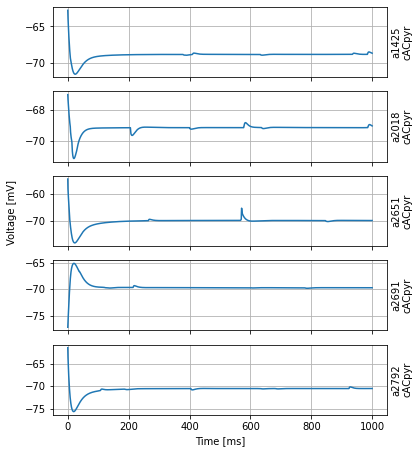

In [24]:
multi_traces(node_ids[:5])

Plot all traces

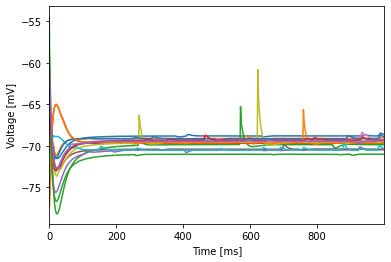

In [25]:
filtered_report_soma.trace(plot_type="all") ;

Plot an average trace

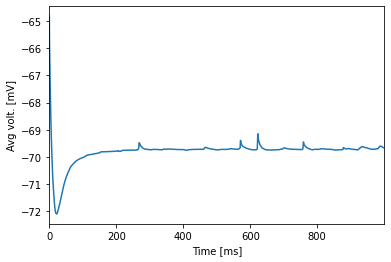

In [26]:
# sample traces mean
filtered_report_soma.trace(plot_type="mean") ;

### Exercise #1

The analyses and plots before include the initial transient, an artifact of the simulation that is due to initial default values of the variables. The initial transient appears as an initial burst of activity at the network level. Replicate all the analyses and plots above excluding the initial transient, that we can consider to last for the first 200 ms. Calculate the mean and std of the mean firing frequency distributions of the cells of the central column. Put the answer in a list called _ans_1_.

In [ ]:
# This is to generate the answers to paste in the submission box below.
# After you defined the variables with your answers, run this cell and the next cell, and copy-paste the output into the box below
print(json.dumps(dict([("ans_1", ans_1)])))

In [ ]:
!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
s.show_submission(ROLLBACK, TOKEN)